In [1]:
# imports for preprocessing
import pandas as pd
import numpy as np
from scipy import stats

# imports for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# imports for machine learning
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# import for exporting model
import pickle

In [2]:
# inital data pre-cleaning
cvd_df = pd.read_csv('cardio_train.csv')
print(cvd_df.shape)
cvd_df.head(10)

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


## Data Pre-processing

Preprocessing carried out:

- Checked for empty columns 
- Checked for duplicates 
- Got rid of ID column 
- Converted age from days to years 
- Combined height and weight into one column (BMI) 
- Renamed ap_hi and ap_lo 
- Got rid of outliers 

In [3]:
# checking for dupliacates and NULL values in rows
print("Duplicate rows :", cvd_df.duplicated().sum())
print("Null cells found :", cvd_df.isnull().values.any())

Duplicate rows : 0
Null cells found : False


In [4]:
# deriving new columns
cvd_df["age_years"] = (cvd_df["age"] / 365).round().astype('int')
cvd_df["BMI"] = cvd_df["weight"] / (cvd_df["height"] / 100) ** 2

# renaming columns
cvd_df = cvd_df.rename(columns={'ap_hi' : 'systolic_blood_pres', 'ap_lo' : 'diastolic_blood_pres'})

# dropping columns I don't need
cvd_df = cvd_df.drop(['id', 'age'], axis=1)

# view sample of changes made
cvd_df.head(10)

,gender,height,weight,systolic_blood_pres,diastolic_blood_pres,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177
5,1,151,67.0,120,80,2,2,0,0,0,0,60,29.384676
6,1,157,93.0,130,80,3,1,0,0,1,0,61,37.729725
7,2,178,95.0,130,90,3,3,0,0,1,1,62,29.983588
8,1,158,71.0,110,70,1,1,0,0,1,0,48,28.440955
9,1,164,68.0,110,60,1,1,0,0,0,0,54,25.282570


## Getting rid of Outliers

### BMI: 

In [5]:
def histogram(column):
    sns.histplot(data=cvd_df, x=column)
    plt.show()

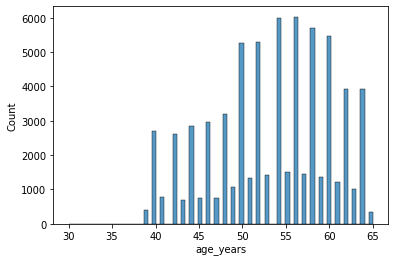

count    70000.000000
mean        53.338686
std          6.765294
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age_years, dtype: float64

In [6]:
histogram('age_years')
cvd_df['age_years'].describe()

All ages are reasonable (around 30 - 65), therefore age variable will not be further processed

In [7]:
def boxplot(column):
    sns.boxplot(x=cvd_df[column])
    plt.show()

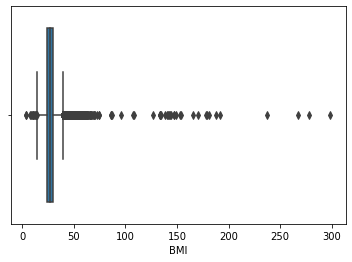

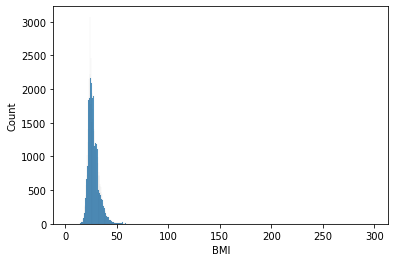

count    70000.000000
mean        27.556513
std          6.091511
min          3.471784
25%         23.875115
50%         26.374068
75%         30.222222
max        298.666667
Name: BMI, dtype: float64

In [8]:
boxplot('BMI')
histogram('BMI')
cvd_df['BMI'].describe()

Many outliers found, and min and max are unrealistic BMIs for a human to have so further cleaning will take place

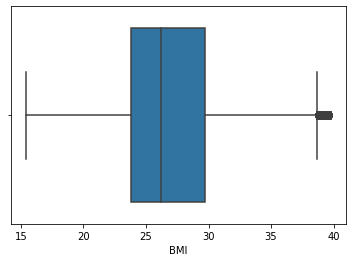

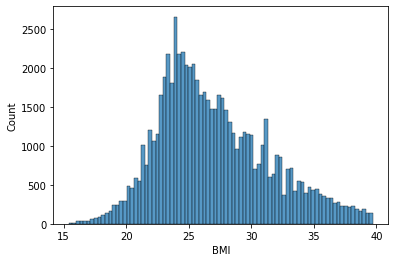

count    67984.000000
mean        27.020790
std          4.442091
min         15.400624
25%         23.833005
50%         26.218821
75%         29.757785
max         39.736121
Name: BMI, dtype: float64

In [9]:
# getting rid of values with a higher z score than 2 
cvd_df = cvd_df[(np.abs(stats.zscore(cvd_df['BMI'])) < 2)]

boxplot('BMI')
histogram('BMI')
cvd_df['BMI'].describe()


Though outliers are still present, it's no where near as extreme as before, data is more realistic now

### Height and Weight: 

In [10]:
def scatter_plot(x, y):
    sns.scatterplot(data=cvd_df, x=x, y=y, hue="cardio")
    plt.show()

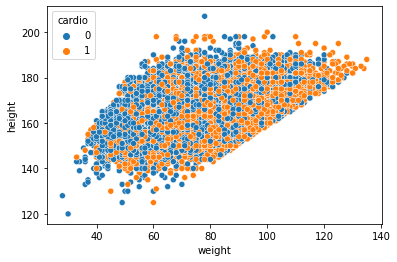

,gender,height,weight,systolic_blood_pres,diastolic_blood_pres,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000,67984.000000
mean,1.355687,164.573238,73.157140,128.377971,95.863674,1.359158,1.221331,0.089139,0.053719,0.804763,0.494072,53.312015,27.020790
std,0.478724,7.811399,12.778702,148.213384,184.291580,0.674179,0.567037,0.284946,0.225463,0.396386,0.499969,6.770829,4.442091
min,1.000000,120.000000,28.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,15.400624
25%,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.833005
50%,1.000000,165.000000,71.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000,26.218821
75%,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,29.757785
max,2.000000,207.000000,135.000000,16020.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000,39.736121


In [11]:
# seeing if height/weight data needs to be cleaned
scatter_plot('weight', 'height')
cvd_df.describe()

height and weight will require further data cleaning as there are unrealistic weights such as 28kg present in the dataset. 

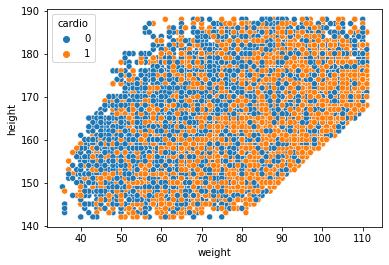

,gender,height,weight,systolic_blood_pres,diastolic_blood_pres,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000,67415.000000
mean,1.352429,164.494252,72.935133,128.324053,95.758896,1.358140,1.220752,0.088230,0.053193,0.805088,0.492873,53.314455,26.973489
std,0.477730,7.611913,12.385429,148.824262,184.544513,0.673477,0.566606,0.283631,0.224420,0.396136,0.499953,6.768928,4.391337
min,1.000000,142.000000,35.450000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,15.400624
25%,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.828125
50%,1.000000,165.000000,71.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000,26.175195
75%,2.000000,170.000000,80.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,29.744200
max,2.000000,188.000000,111.000000,16020.000000,10000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000,39.736121


In [12]:
# getting rid of values with a higher z score than 3 
cvd_df = cvd_df[(np.abs(stats.zscore(cvd_df['height'])) < 3)]
cvd_df = cvd_df[(np.abs(stats.zscore(cvd_df['weight'])) < 3)]

scatter_plot('weight', 'height')
cvd_df.describe()

### systolic blood pressure:

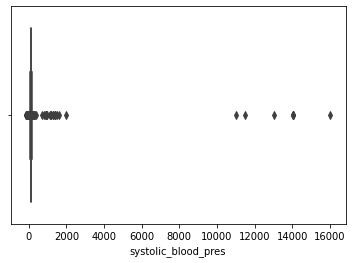

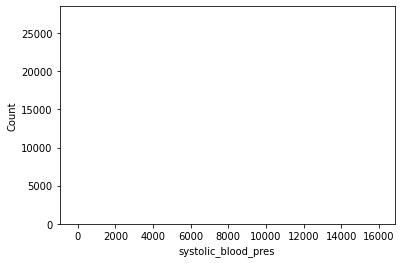

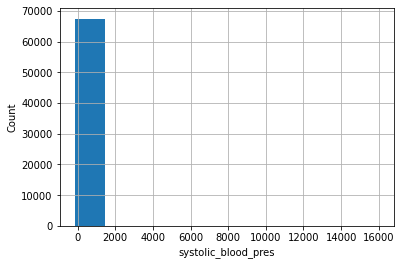

count    67415.000000
mean       128.324053
std        148.824262
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: systolic_blood_pres, dtype: float64

In [13]:
boxplot('systolic_blood_pres')

# for histograms, I prefer to use seaborn, however due to so many outliers, this outputs a histogram that looks blank
histogram('systolic_blood_pres')

# graph with visible data
cvd_df['systolic_blood_pres'].hist()
plt.xlabel('systolic_blood_pres')
plt.ylabel('Count')
plt.show()

cvd_df['systolic_blood_pres'].describe()

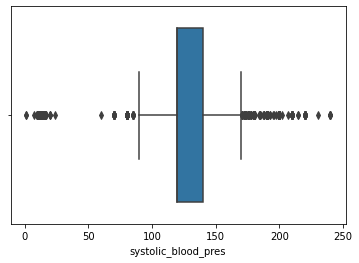

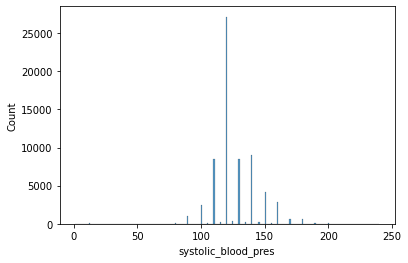

count    67369.000000
mean       126.322493
std         17.813784
min          1.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        240.000000
Name: systolic_blood_pres, dtype: float64

In [14]:
z_score_test_cvd_df = cvd_df[(np.abs(stats.zscore(cvd_df['systolic_blood_pres'])) < 1)]

sns.boxplot(x=z_score_test_cvd_df['systolic_blood_pres'])
plt.show()

sns.histplot(x=z_score_test_cvd_df['systolic_blood_pres'])
plt.show()

z_score_test_cvd_df['systolic_blood_pres'].describe()

Different approach than z score will be used for getting rid of outliers as unrealistic values are still present (Min value being 1 and Max being 240 ).

New approach used will be to find realistic range of blood pressures (referencing NHS website) and getting rid of values that fall outside of that range

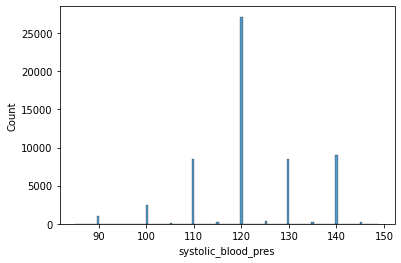

count    58265.000000
mean       121.881833
std         11.209501
min         85.000000
25%        120.000000
50%        120.000000
75%        130.000000
max        149.000000
Name: systolic_blood_pres, dtype: float64

In [15]:
cvd_df = cvd_df[cvd_df['systolic_blood_pres'] > 80]
cvd_df = cvd_df[cvd_df['systolic_blood_pres'] < 150]

histogram('systolic_blood_pres')
cvd_df['systolic_blood_pres'].describe()

### Diastolic blood pressure:

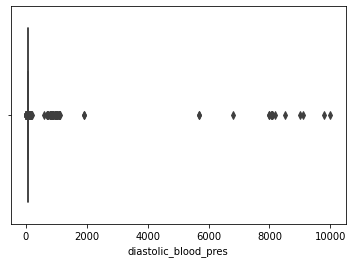

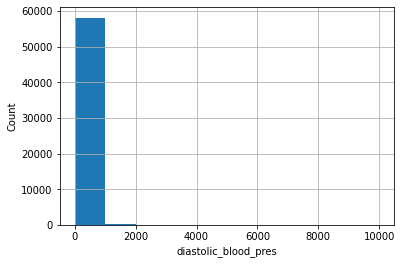

count    58265.000000
mean        85.363271
std        149.532333
min          0.000000
25%         80.000000
50%         80.000000
75%         80.000000
max      10000.000000
Name: diastolic_blood_pres, dtype: float64

In [16]:
# same process applied to systolic pressure applied to diastolic
boxplot('diastolic_blood_pres')

cvd_df['diastolic_blood_pres'].hist()
plt.xlabel('diastolic_blood_pres')
plt.ylabel('Count')
plt.show()

cvd_df['diastolic_blood_pres'].describe()

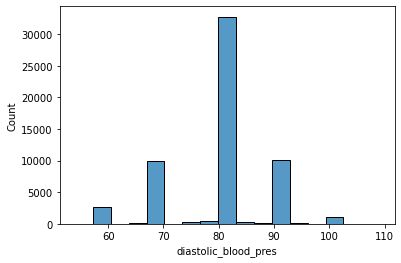

count    57859.000000
mean        79.500579
std          7.844139
min         54.000000
25%         80.000000
50%         80.000000
75%         80.000000
max        109.000000
Name: diastolic_blood_pres, dtype: float64

In [17]:
cvd_df = cvd_df[cvd_df['diastolic_blood_pres'] > 50]
cvd_df = cvd_df[cvd_df['diastolic_blood_pres'] < 110]

histogram('diastolic_blood_pres')
cvd_df['diastolic_blood_pres'].describe()

## Data Visualisation

In [18]:
# viewing dataframe after cleansing 
cvd_df.describe()

,gender,height,weight,systolic_blood_pres,diastolic_blood_pres,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000,57859.000000
mean,1.345806,164.536373,72.221974,121.849220,79.500579,1.328229,1.210598,0.086123,0.051142,0.803401,0.435663,53.014622,26.694907
std,0.475634,7.539136,12.109067,11.143735,7.844139,0.653456,0.558464,0.280548,0.220288,0.397430,0.495848,6.791385,4.287804
min,1.000000,142.000000,35.450000,85.000000,54.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.000000,15.400624
25%,1.000000,159.000000,64.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.000000,23.661439
50%,1.000000,165.000000,70.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,54.000000,25.909457
75%,2.000000,170.000000,80.000000,130.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.000000,29.352355
max,2.000000,188.000000,111.000000,149.000000,109.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,65.000000,39.736121


### comparisons between gender:

Note: 1 = women, 2 = men

1    37851
2    20008
Name: gender, dtype: int64
Women with cardiovascular disease :  16500
Men with cardiovascular disease :  8707


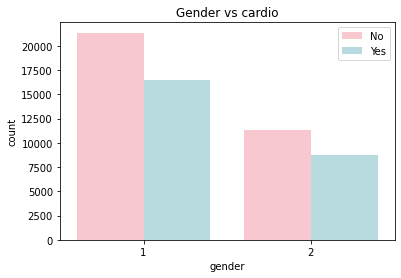

In [19]:
sns.countplot(data=cvd_df, x='gender', hue='cardio', palette=['pink', 'powderblue']).set_title('Gender vs cardio')
plt.legend(labels=['No', 'Yes'])

print(cvd_df['gender'].value_counts())

print('Women with cardiovascular disease : ',len(cvd_df[(cvd_df['gender']==1) & (cvd_df['cardio']==1)]))
print('Men with cardiovascular disease : ',len(cvd_df[(cvd_df['gender']==2) & (cvd_df['cardio']==1)]))

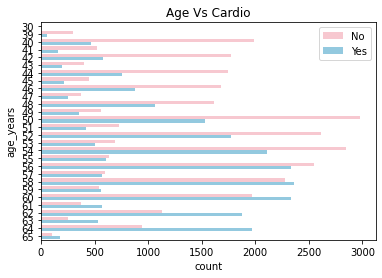

In [20]:
sns.countplot(data=cvd_df, y='age_years', hue='cardio', palette=['pink', 'skyblue']).set_title('Age Vs Cardio')
plt.legend(labels=['No', 'Yes'])

In [21]:
def histogram_cardio(x):
    sns.histplot(data=cvd_df, x=x, hue='cardio', palette=['purple', 'blue']).set_title('Cardio Vs ' + x)
    plt.legend(labels=['Yes', 'No'])
    plt.show()

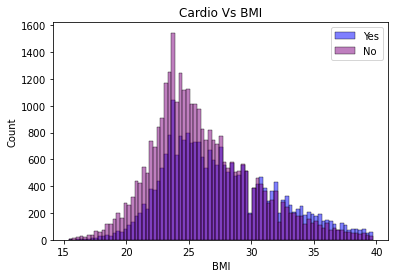

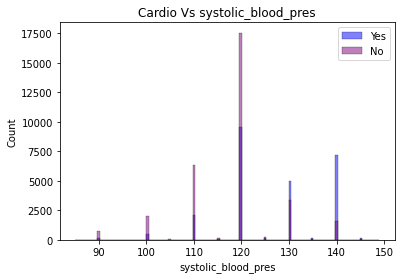

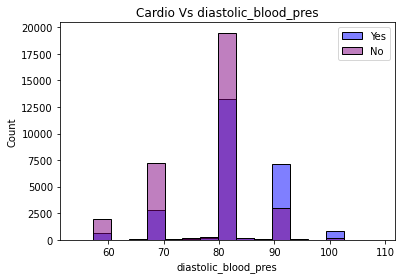

In [22]:
histogram_cardio('BMI')
histogram_cardio('systolic_blood_pres')
histogram_cardio('diastolic_blood_pres')

In [23]:
def countplot_cardio(val, palette, labels):
    sns.countplot(data=cvd_df, x="cardio", hue=val, palette=palette).set_title('Cardio vs ' + val)
    plt.legend(labels=labels)
    plt.show()

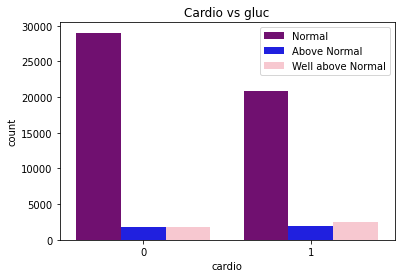

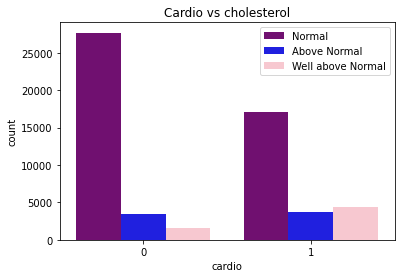

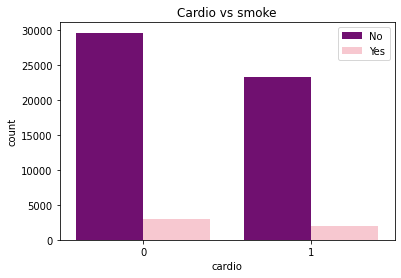

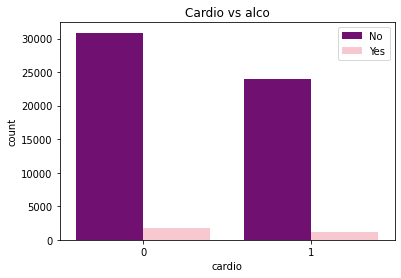

In [24]:
countplot_cardio('gluc', ['purple', 'blue', 'pink'], ['Normal', 'Above Normal', 'Well above Normal'])
countplot_cardio('cholesterol', ['purple', 'blue', 'pink'], ['Normal', 'Above Normal', 'Well above Normal'])
countplot_cardio('smoke', ['purple', 'pink'], ['No', 'Yes'])
countplot_cardio('alco', ['purple', 'pink'], ['No', 'Yes'])

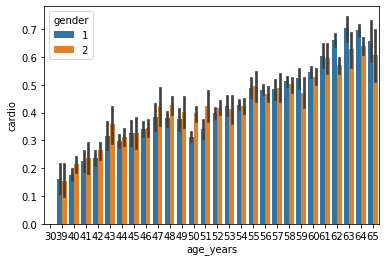

<AxesSubplot:xlabel='alco', ylabel='cardio'>

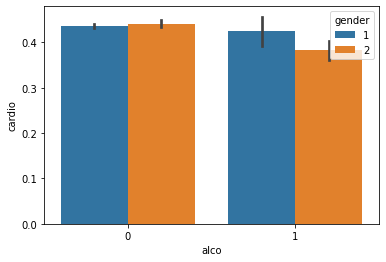

In [25]:
sns.barplot(x='age_years', y='cardio', hue='gender', data=cvd_df)
plt.show()

sns.barplot(data=cvd_df, x="alco", y="cardio", hue="gender")

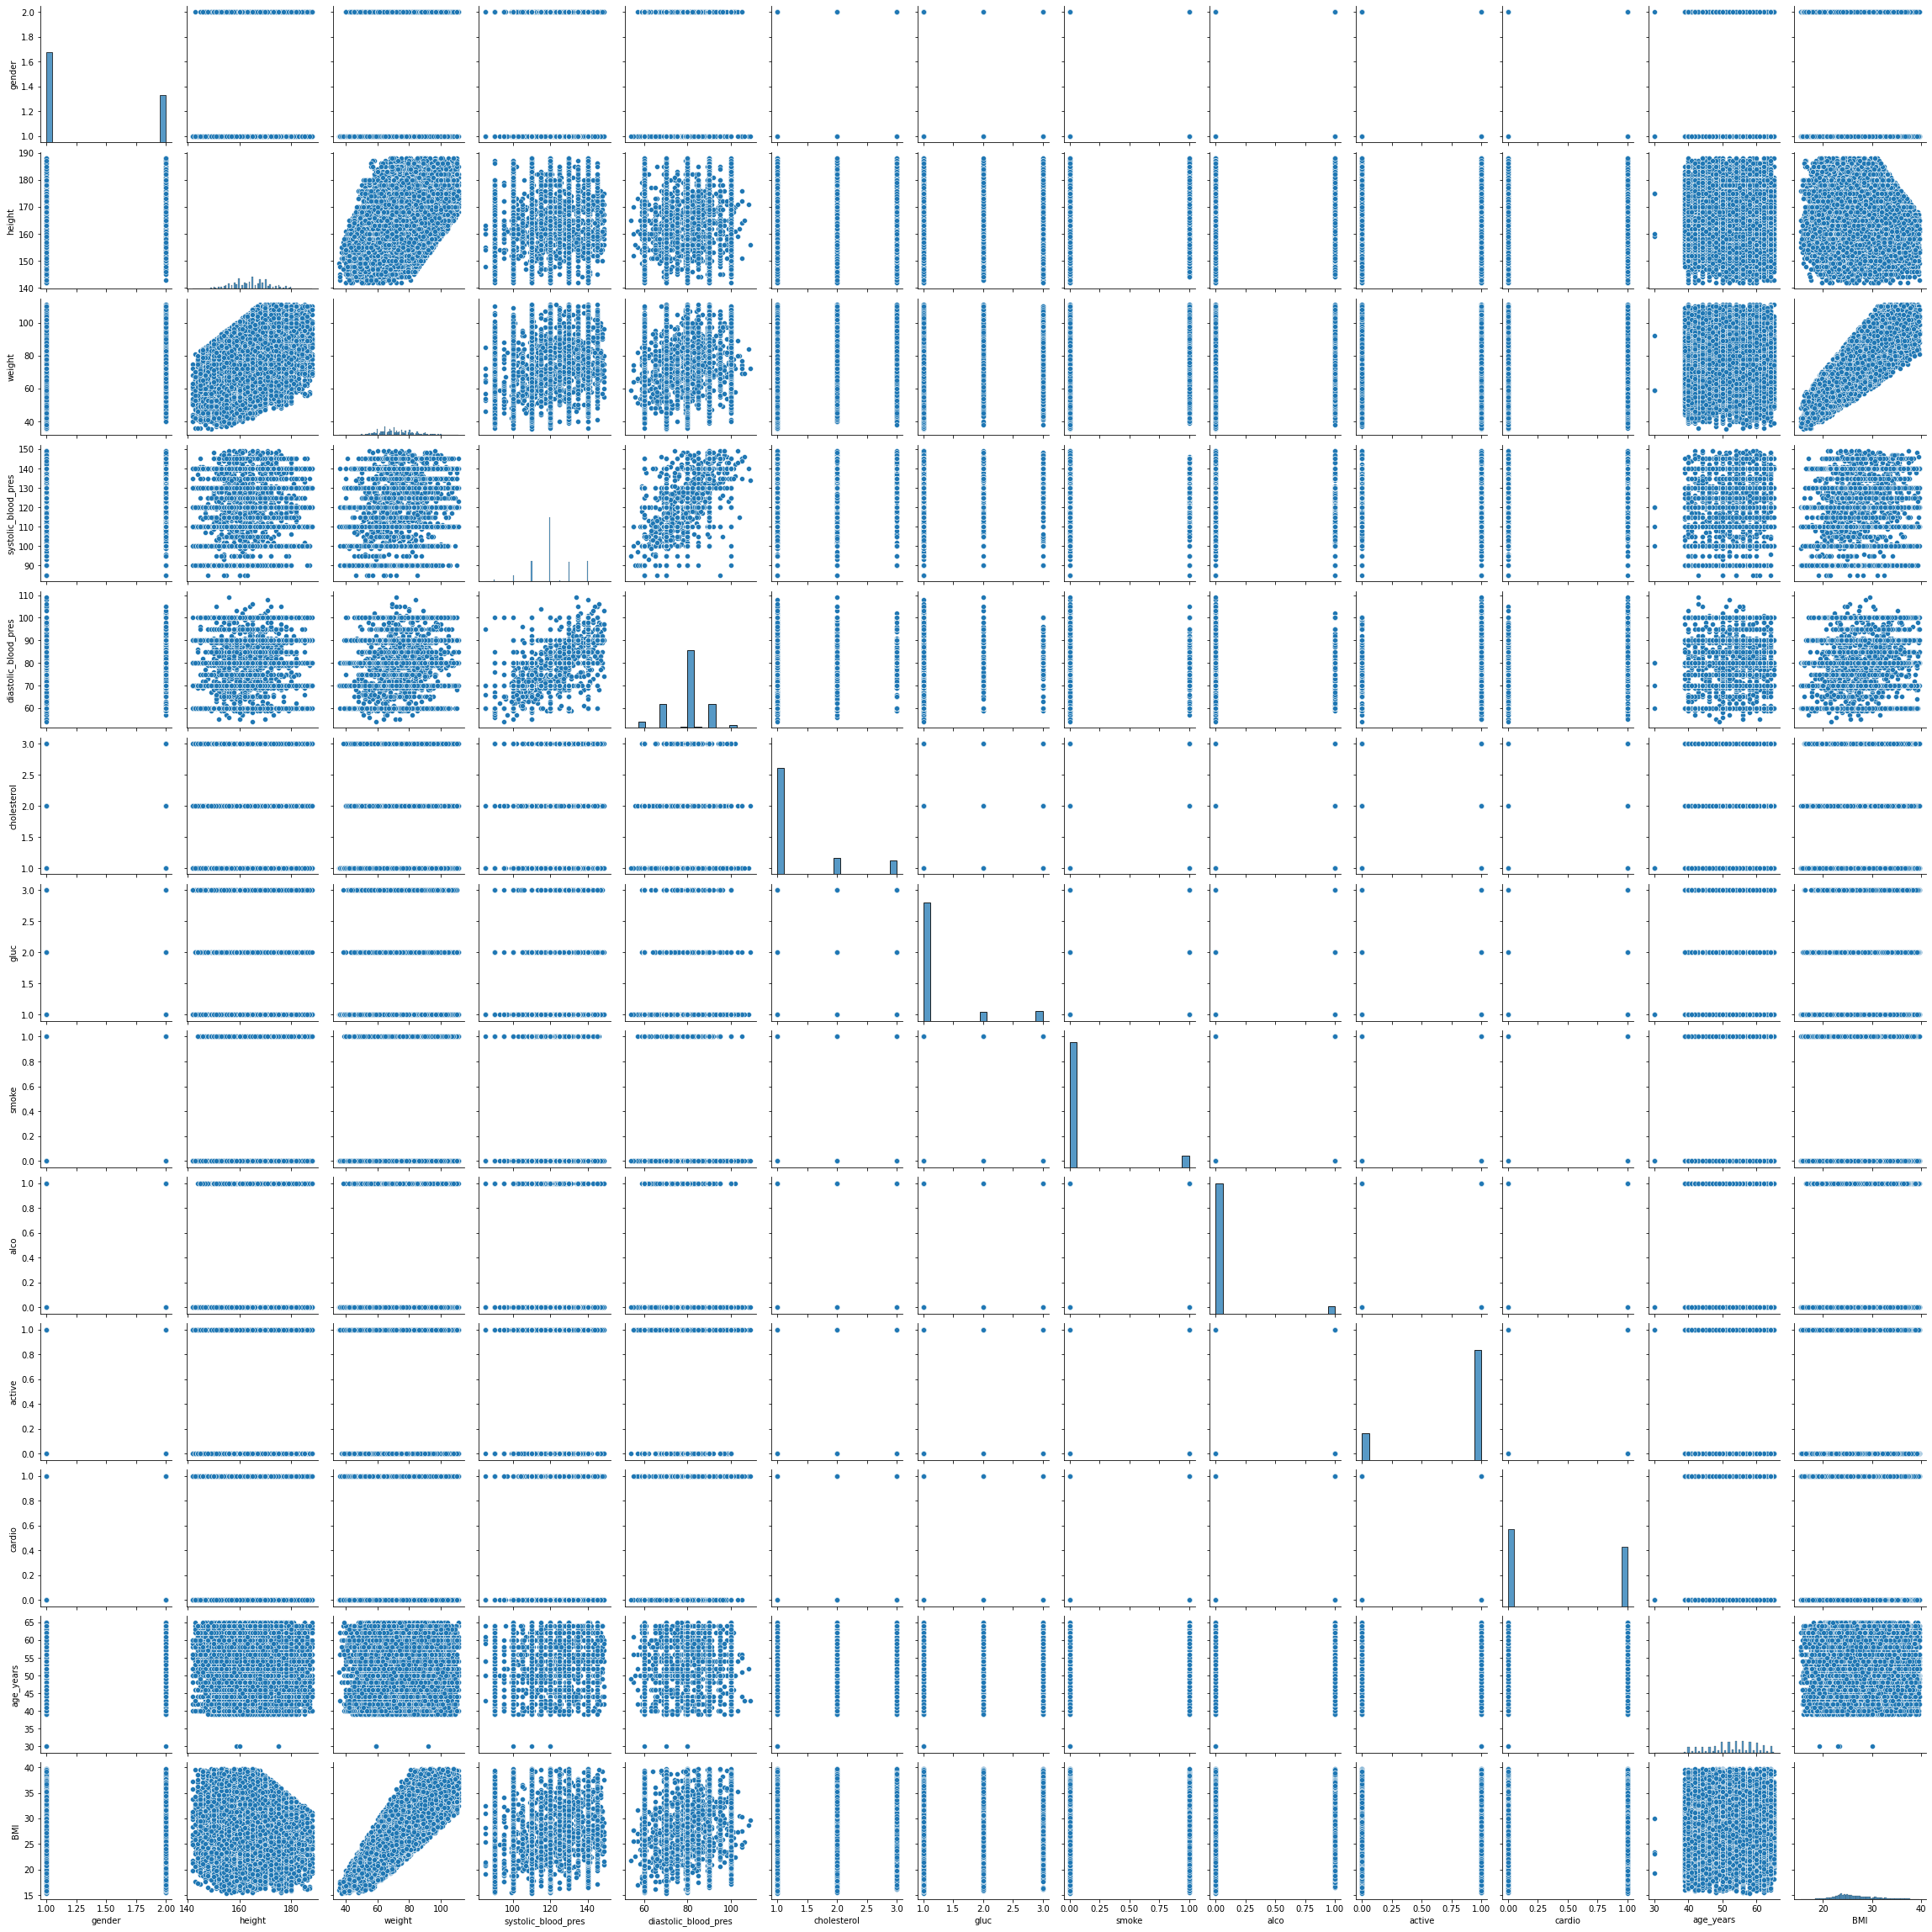

In [26]:
# scatterplot matrix to visualise any correlations 
sns.pairplot(cvd_df)

<AxesSubplot:>

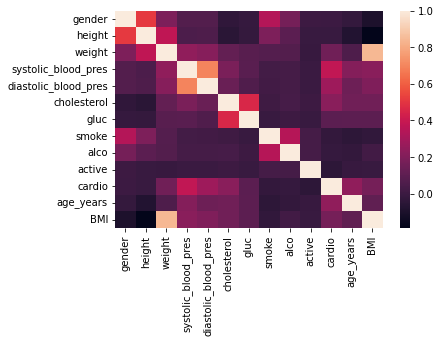

In [27]:
# correlation matrix - to visualise correlations in a freindlier form than scatterplot matrix
corr = cvd_df.corr()
sns.heatmap(corr)

## Training models

In order to get the best possible prediction model for the CVD Web Application (As false postives/negatives will cause issues, especially in regards to healthcare), multiple models with be trained and tested. 

The techniques I will analyse will be:

- Logistic Regression
- Multiple Linear Regression
- Decision Trees
- Random Forest
- Guassian Naive Bayes
- K-nearest Neighbours
- Support Vector Machine
- Gradient Boosting 
- Extreme Gradient Boosting
- Neural Networks (MLP)

In [28]:
# values used for prediction (all variables in data frames except 'cardio')
x = cvd_df.drop('cardio', axis=1)

# variable to be predcited (of patient has CVD or not)
y = cvd_df['cardio']

# train test split (80/20 split)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

In [29]:
def report(model):
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred))


In [30]:
def mse(model):
    y_pred = model.predict(x_test)
    print('mean_squared_error : ', mean_squared_error(y_test, y_pred))

In [31]:
def generate_confusion_matrix(model):
    y_pred = model.predict(x_train)
    cm = metrics.confusion_matrix(y_train, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix= cm, display_labels = [False, True])

    cm_display.plot()
    plt.show()
    

In [32]:
def evaluation(model):
    report(model)
    mse(model)
    generate_confusion_matrix(model)

### Logistic Regression

In [33]:
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=3000).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.71      0.81      0.76      6541
           1       0.70      0.57      0.63      5031

    accuracy                           0.70     11572
   macro avg       0.70      0.69      0.69     11572
weighted avg       0.70      0.70      0.70     11572

mean_squared_error :  0.29571379191151054


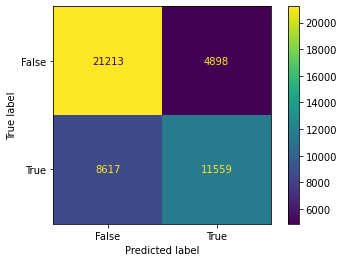

In [34]:
evaluation(logistic_regression)

### Multiple Linear Regression

In [35]:
multiple_linear_regression = LinearRegression().fit(x_train, y_train)

# model is a regression model so classification evaluations (i.e confusion matrix) cannot be used 
mse(multiple_linear_regression)

mean_squared_error :  0.19941684413668484


### Decision Tree

In [36]:
decision_tree = DecisionTreeClassifier().fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.66      0.67      0.66      6541
           1       0.56      0.54      0.55      5031

    accuracy                           0.62     11572
   macro avg       0.61      0.61      0.61     11572
weighted avg       0.61      0.62      0.61     11572

mean_squared_error :  0.38454891116488077


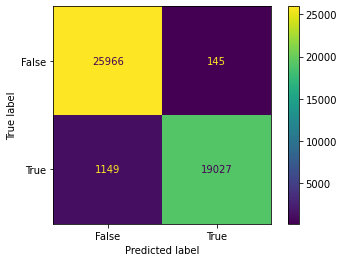

In [37]:
evaluation(decision_tree)

### Random Forest

In [38]:
random_forest = RandomForestClassifier().fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      6541
           1       0.64      0.60      0.62      5031

    accuracy                           0.68     11572
   macro avg       0.68      0.67      0.67     11572
weighted avg       0.68      0.68      0.68     11572

mean_squared_error :  0.3172312478396129


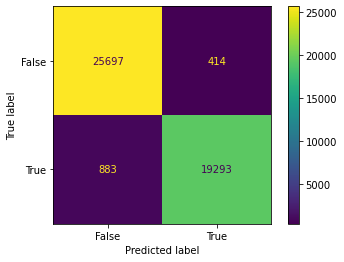

In [39]:
evaluation(random_forest)

### Guassain Naive Bayes

In [40]:
guassain_naive_bayes = GaussianNB().fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.70      0.80      0.74      6541
           1       0.68      0.55      0.61      5031

    accuracy                           0.69     11572
   macro avg       0.69      0.67      0.68     11572
weighted avg       0.69      0.69      0.68     11572

mean_squared_error :  0.3102315935015555


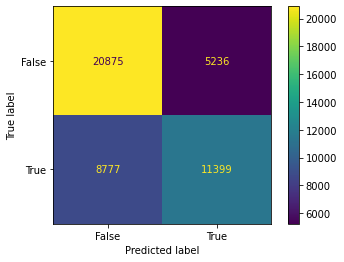

In [41]:
evaluation(guassain_naive_bayes)

### K-nearest Neighbours

In [42]:
k_nearest_neighbours = KNeighborsClassifier(n_neighbors=15).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.70      0.79      0.74      6541
           1       0.67      0.56      0.61      5031

    accuracy                           0.69     11572
   macro avg       0.68      0.67      0.67     11572
weighted avg       0.68      0.69      0.68     11572

mean_squared_error :  0.31403387487037676


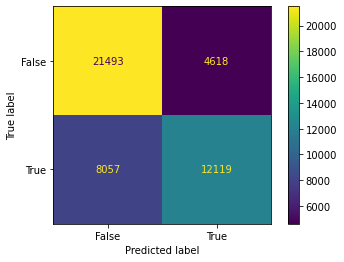

In [43]:
evaluation(k_nearest_neighbours)

### Support Vector Machine

In [44]:
support_vector_machine = svm.SVC().fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.67      0.88      0.76      6541
           1       0.74      0.44      0.55      5031

    accuracy                           0.69     11572
   macro avg       0.71      0.66      0.66     11572
weighted avg       0.70      0.69      0.67     11572

mean_squared_error :  0.30893536121673004


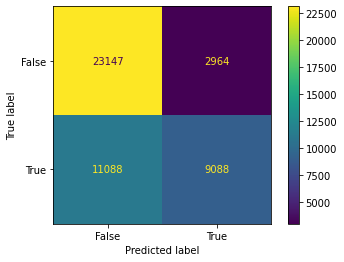

In [45]:
evaluation(support_vector_machine)

### Gradient Boosting Classifier

In [46]:
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=175, learning_rate=1.0, max_depth=1, random_state=42).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.71      0.83      0.76      6541
           1       0.71      0.55      0.62      5031

    accuracy                           0.71     11572
   macro avg       0.71      0.69      0.69     11572
weighted avg       0.71      0.71      0.70     11572

mean_squared_error :  0.2909609402004839


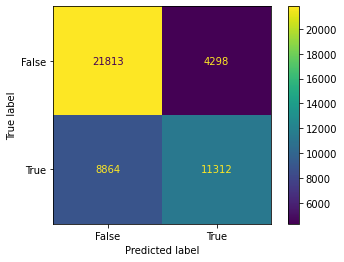

In [47]:
evaluation(gradient_boosting_classifier)

### XGBoost Model

In [48]:
xgb = XGBClassifier(n_estimators=450, max_depth=3).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6541
           1       0.70      0.58      0.64      5031

    accuracy                           0.71     11572
   macro avg       0.71      0.70      0.70     11572
weighted avg       0.71      0.71      0.71     11572

mean_squared_error :  0.28923263048738335


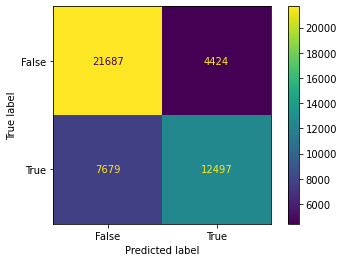

In [49]:
evaluation(xgb)

### Neural Network 1 (MLP Classifier)

In [50]:
mlp_classifier = MLPClassifier(activation='tanh', solver='adam', max_iter=800, learning_rate='adaptive', random_state=2).fit(x_train, y_train)

              precision    recall  f1-score   support

           0       0.72      0.81      0.76      6541
           1       0.70      0.58      0.64      5031

    accuracy                           0.71     11572
   macro avg       0.71      0.69      0.70     11572
weighted avg       0.71      0.71      0.70     11572

mean_squared_error :  0.2908745247148289


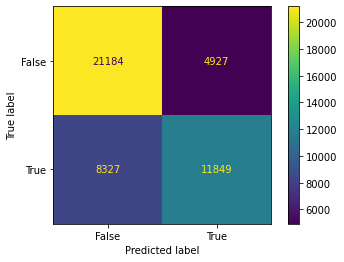

In [51]:
evaluation(mlp_classifier)

In [52]:
# xgb model has highest accuracy and lowest MSE so is exported for use in UI

with open('cvd_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)